<a href="https://colab.research.google.com/github/kunal1709/MIS-64099-Capstone/blob/main/Humana_Kunal1_FeatureEngineering_And_Model_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import warnings
import gc
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

In [3]:
df_t  = pd.read_csv('/content/drive/MyDrive/DataSet2020/transformed_dataset.csv' ,low_memory=False)
df_t.head()

,covid_vaccination,sex_cd,bh_ip_snf_mbr_resp_pmpm_cost_9to12m_b4,auth_3mth_acute_inf,rx_maint_pmpm_ct_t_6-3-0m_b4,auth_3mth_home,rx_mail_mbr_resp_pmpm_cost_t_9-6-3m_b4,cms_orig_reas_entitle_cd,auth_3mth_post_acute_mus,auth_3mth_acute_dia,src_div_id,atlas_type_2015_recreation_no,auth_3mth_acute_inj,auth_3mth_dc_ltac,rx_nonbh_pmpm_ct_t_9-6-3m_b4,auth_3mth_acute_bld,total_physician_office_net_paid_pmpm_cost_t_9-6-3m_b4,auth_3mth_acute_ccs_153,atlas_hiamenity,rx_maint_pmpm_cost_t_6-3-0m_b4,atlas_population_loss_2015_update,rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4,rx_overall_mbr_resp_pmpm_cost_t_6-3-0m_b4,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4,auth_3mth_bh_acute,rx_overall_dist_gpi6_pmpm_ct_t_6-3-0m_b4,rev_cms_ansth_pmpm_ct,auth_3mth_post_acute_end,atlas_persistentchildpoverty_1980_2011,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4,auth_3mth_post_acute_dig,auth_3mth_post_acute_cir,auth_3mth_bh_acute_mean_los,auth_3mth_dc_home,auth_3mth_post_acute,rx_gpi2_33_pmpm_ct_0to3m_b4,total_med_net_paid_pmpm_cost_t_6-3-0m_b4,total_allowed_pmpm_cost_t_9-6-3m_b4,auth_3mth_post_acute_ckd,auth_3mth_acute_mus,...,atlas_pct_laccess_nhna15,atlas_totalocchu,atlas_pct_laccess_lowi15,atlas_pct_nslp15,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,cms_tot_partd_payment_amt,rx_maint_pmpm_ct_9to12m_b4,rx_nonbh_mbr_resp_pmpm_cost_6to9m_b4,atlas_pct_sfsp15,rwjf_air_pollute_density,atlas_pct_cacfp15,bh_ncdm_pct,atlas_pc_ffrsales12,rx_nonbh_net_paid_pmpm_cost,total_outpatient_allowed_pmpm_cost_6to9m_b4,atlas_pct_fmrkt_wic16,credit_bal_consumerfinance,rx_nonbh_pmpm_ct_0to3m_b4,atlas_berry_acrespth12,rx_overall_mbr_resp_pmpm_cost,rx_branded_mbr_resp_pmpm_cost,rx_tier_2_pmpm_ct_3to6m_b4,credit_bal_autobank,atlas_pct_laccess_child15,atlas_pct_laccess_nhasian15,atlas_dirsales_farms12,rx_hum_16_pmpm_ct,atlas_pct_laccess_hhnv15,rx_days_since_last_script_6to9m_b4,atlas_pct_laccess_snap15,atlas_povertyunder18pct,atlas_medhhinc,auth_3mth_acute_mean_los,atlas_veg_acrespth12,atlas_netmigrationrate1016,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_multir15,rx_nonotc_dist_gpi6_pmpm_ct,atlas_pct_obese_adults13,atlas_orchard_acrespth12
0,0,1,1,0,0,1,4,0,0,0,2,0,0,1,4,1,9,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0,1,1,1,2,9,9,0,0,...,0.036550,16416.0,8.809361,12.218996,0.00,28.89,1.333333,50.546665,0.534684,8.0,1.412746,0.0,479.492780,24.014165,0.00,0.0,832.960852,2.000000,0.000000,14.424166,0.0,1.000000,6434.326769,7.910346,0.071579,17.0,0.833333,1.150322,217,1.458254,18.3,56861.0,0.0,4.181879,9.775188,0.0,1.260405,0.500000,33.2,0.000000
1,0,1,2,0,0,1,8,0,0,0,2,0,0,1,8,1,9,0,0,4,0,2,4,8,1,4,1,0,0,1,0,0,1,1,1,2,9,9,0,0,...,0.028851,99660.0,4.217246,11.180060,0.00,28.81,0.000000,0.000000,0.961838,10.3,1.704639,0.0,521.238200,9.497500,0.00,0.0,814.885956,3.666667,0.043390,27.267500,0.0,1.666667,7183.751526,1.730272,0.280467,116.0,1.250000,2.447362,120,1.063555,12.6,55828.0,0.0,0.646902,9.931234,0.0,0.310503,1.250000,32.9,0.156425
2,0,1,1,0,10,1,10,1,0,0,2,0,0,1,8,1,1,0,0,10,0,1,4,0,1,4,11,0,0,1,0,0,1,1,1,1,4,2,0,0,...,0.086740,23811.0,7.809896,9.865436,0.17,151.83,0.333333,0.000000,1.359437,9.0,0.800732,0.0,632.196141,4.733333,4192.19,0.0,1796.896312,1.333333,0.040506,23.571666,0.0,0.000000,4952.314364,5.015501,0.000395,33.0,0.000000,2.212277,231,2.516320,17.3,61903.0,0.0,7.431193,5.555760,0.0,0.773873,0.333333,35.0,1.037510
3,0,1,1,0,0,1,4,0,0,0,2,0,0,1,0,1,9,0,0,1,0,1,1,0,1,10,1,0,0,1,0,0,1,1,1,1,9,11,0,0,...,0.167049,70150.0,10.317817,12.101522,0.00,83.67,1.333333,27.413333,0.991095,10.7,1.387364,0.0,666.146008,1.697500,0.00,0.0,961.138780,1.333333,0.000000,6.016667,0.0,0.000000,3840.454257,4.049586,0.849008,3.0,0.416667,1.527418,199,5.050701,33.7,41694.0,0.0,0.027000,2.118735,0.0,1.950803,0.416667,37.1,9.094149
4,0,1,1,0,1,1,9,0,0,0,2,0,0,1,4,1,9,0,1,1,0,1,9,4,1,10,1,0,0,1,0,0,1,1,1,4,9,9,0,0,...,0.035950,106124.0,3.923556,8.358339,0.00,76.15,1.333333,0.000000,0.327121,8.7,1.438477,0.0,642.487457,48.255000,0.00,30.0,540.459213,1.666667,0.322768,0.000000,0.0,0.333333,6185.369020,0.618606,0.885394

In [4]:
def Standardize(data,istest=False):
  print("Start Standardizing...")
  # Standardize all features
  scaler = StandardScaler()
  #del data_X
  data_int_s = scaler.fit_transform(data.astype(float))
  data_int_s = pd.DataFrame(data_int_s, columns=data.columns,dtype="float32")# concat later
  #del data_int
  #if not istest:
   # df = pd.concat([data_int_s,data_ord,label],axis=1)
  #lse:
   # df = pd.concat([data_int_s,data_ord],axis=1)
  print("Standardizing completed!")
  return data_int_s

In [5]:
def SplitXy(data):
  df = data.copy()
  y = df.loc[:,"covid_vaccination"]
  X = df.drop(columns = ["covid_vaccination"])
  return X, y

In [6]:
X,y = SplitXy(df_t)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1204)

In [ ]:
y_train.shape

(731131,)

In [9]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

In [11]:
import lightgbm as lgb

In [8]:
#Standardizing the data
#del s_df_t 
#del X_train_std
#del X_test
X_train= Standardize(X_train)
X_test=Standardize(X_test)

Start Standardizing...
Standardizing completed!
Start Standardizing...
Standardizing completed!


In [12]:
gbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
              objective="binary", 
              metric = 'auc',
              random_state = 1204,
              max_depth = 12,
              num_leaves = 42,
              learning_rate = 0.05,
              n_estimators = 500)
gbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=12, metric='auc', n_estimators=500,
               num_leaves=42, objective='binary', random_state=1204)

In [14]:
gbm_eval = evaluate_model(gbm, X_test, y_test)

# Print result
print('Accuracy:', gbm_eval['acc'])
print('Precision:', gbm_eval['prec'])
print('Recall:', gbm_eval['rec'])
print('F1 Score:', gbm_eval['f1'])
print('Cohens Kappa Score:', gbm_eval['kappa'])
print('Area Under Curve:', gbm_eval['auc'])
print('Confusion Matrix:\n', gbm_eval['cm'])

Accuracy: 0.8251904920171843
Precision: 0.5304878048780488
Recall: 0.004082302981958098
F1 Score: 0.008102256059230284
Cohens Kappa Score: 0.005445645065812577
Area Under Curve: 0.6806147897296391
Confusion Matrix:
 [[200934    154]
 [ 42449    174]]


In [ ]:
y_pred = gbm.predict_proba(X_test)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_pred[:,1])
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
roc_auc_lr

0.6806147897296391

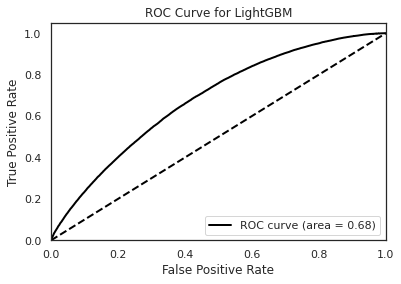

In [ ]:
plt.figure()
sns.set_style("white")
lw = 2
plt.plot(fpr_lr, tpr_lr, color='#000000',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='#000000', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


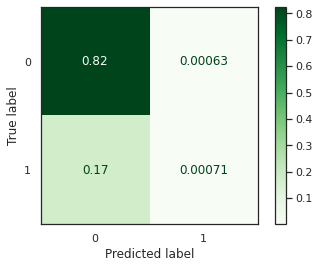

In [ ]:
fig, ax = plt.subplots()
sns.set_theme(style="white")
metrics.plot_confusion_matrix(gbm,X_test,y_test,cmap=plt.cm.Greens,normalize="all",ax = ax)
plt.show()

In [ ]:
model = lgb.LGBMClassifier(boosting_type = 'gbdt',
              objective="binary", 
              metric = 'auc',
              random_state = 1204,
              max_depth = 12,
              num_leaves = 42,
              learning_rate = 0.05,
              n_estimators = 500).fit(X_train, y_train)

In [ ]:
model.importance_type = "gain"

In [ ]:
import seaborn as sns
def plotImp(model, X , num = 20,fig_size=(20,20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_ ,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.set_style("whitegrid")
    sns.barplot(x="Value", y="Feature", 
          data=feature_imp.sort_values(by="Value",ascending=False)[0:num],
          palette = sns.light_palette("#000000",reverse=True,n_colors=100))    
    plt.title('LightGBM Features Importance (Top 100)')
    plt.tight_layout()
    plt.xlabel("Total gains of splits")
    plt.savefig('lgbm_importances-01.png')
    plt.show()

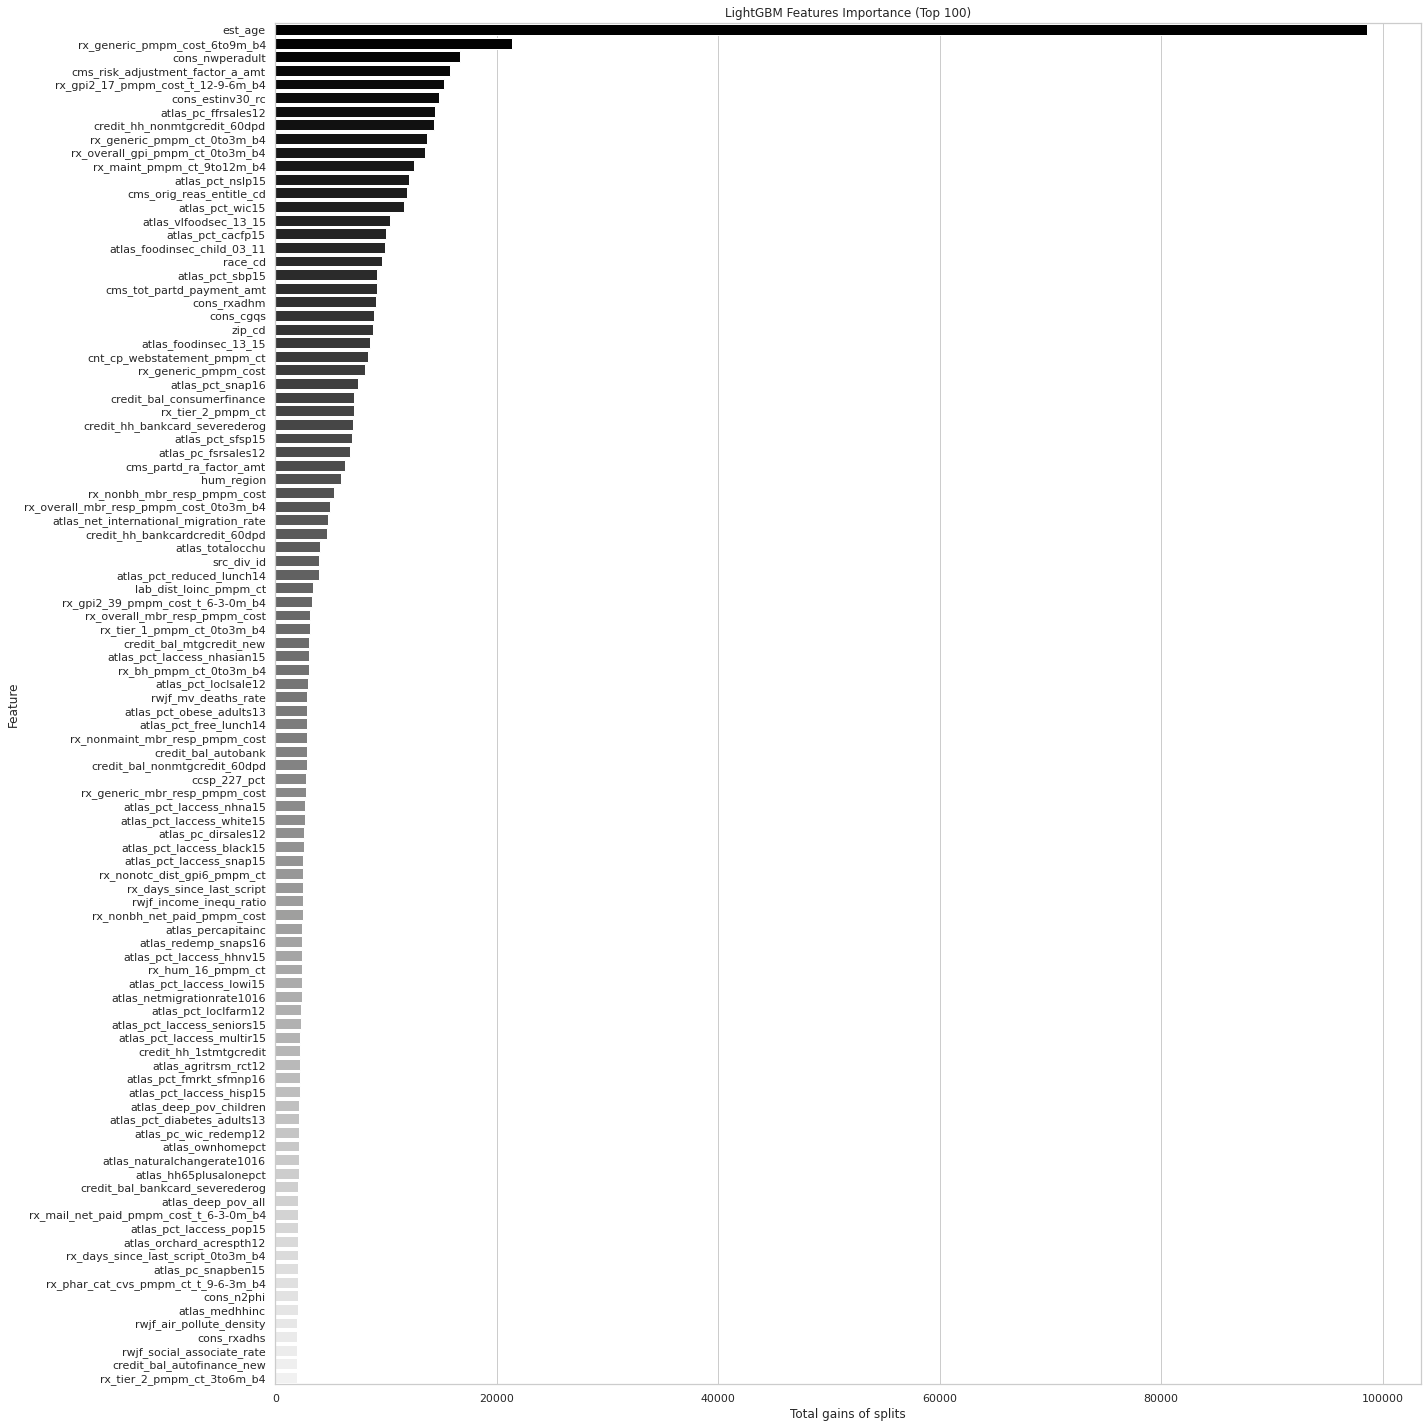

In [ ]:
plotImp(model, X_train , num = 100)

In [ ]:
Feature_Imp = pd.DataFrame({"Feature":X.columns.to_list(),"Importance":model.feature_importances_.tolist()}).sort_values(by = "Importance",ascending = False).reset_index(drop = True)


In [ ]:
Feature_Imp.head(50).to_csv("/content/drive/MyDrive/DataSet2020/50 most important features.csv")

In [ ]:
impf = Feature_Imp.head(50).Feature.to_list()
impf.append("covid_vaccination")
print(impf)
df_imp = df_t.loc[:,impf]
df_imp

['est_age', 'rx_generic_pmpm_cost_6to9m_b4', 'cons_nwperadult', 'cms_risk_adjustment_factor_a_amt', 'rx_gpi2_17_pmpm_cost_t_12-9-6m_b4', 'cons_estinv30_rc', 'atlas_pc_ffrsales12', 'credit_hh_nonmtgcredit_60dpd', 'rx_generic_pmpm_ct_0to3m_b4', 'rx_overall_gpi_pmpm_ct_0to3m_b4', 'rx_maint_pmpm_ct_9to12m_b4', 'atlas_pct_nslp15', 'cms_orig_reas_entitle_cd', 'atlas_pct_wic15', 'atlas_vlfoodsec_13_15', 'atlas_pct_cacfp15', 'atlas_foodinsec_child_03_11', 'race_cd', 'atlas_pct_sbp15', 'cms_tot_partd_payment_amt', 'cons_rxadhm', 'cons_cgqs', 'zip_cd', 'atlas_foodinsec_13_15', 'cnt_cp_webstatement_pmpm_ct', 'rx_generic_pmpm_cost', 'atlas_pct_snap16', 'credit_bal_consumerfinance', 'rx_tier_2_pmpm_ct', 'credit_hh_bankcard_severederog', 'atlas_pct_sfsp15', 'atlas_pc_fsrsales12', 'cms_partd_ra_factor_amt', 'hum_region', 'rx_nonbh_mbr_resp_pmpm_cost', 'rx_overall_mbr_resp_pmpm_cost_0to3m_b4', 'atlas_net_international_migration_rate', 'credit_hh_bankcardcredit_60dpd', 'atlas_totalocchu', 'src_div_id',

,est_age,rx_generic_pmpm_cost_6to9m_b4,cons_nwperadult,cms_risk_adjustment_factor_a_amt,rx_gpi2_17_pmpm_cost_t_12-9-6m_b4,cons_estinv30_rc,atlas_pc_ffrsales12,credit_hh_nonmtgcredit_60dpd,rx_generic_pmpm_ct_0to3m_b4,rx_overall_gpi_pmpm_ct_0to3m_b4,rx_maint_pmpm_ct_9to12m_b4,atlas_pct_nslp15,cms_orig_reas_entitle_cd,atlas_pct_wic15,atlas_vlfoodsec_13_15,atlas_pct_cacfp15,atlas_foodinsec_child_03_11,race_cd,atlas_pct_sbp15,cms_tot_partd_payment_amt,cons_rxadhm,cons_cgqs,zip_cd,atlas_foodinsec_13_15,cnt_cp_webstatement_pmpm_ct,rx_generic_pmpm_cost,atlas_pct_snap16,credit_bal_consumerfinance,rx_tier_2_pmpm_ct,credit_hh_bankcard_severederog,atlas_pct_sfsp15,atlas_pc_fsrsales12,cms_partd_ra_factor_amt,hum_region,rx_nonbh_mbr_resp_pmpm_cost,rx_overall_mbr_resp_pmpm_cost_0to3m_b4,atlas_net_international_migration_rate,credit_hh_bankcardcredit_60dpd,atlas_totalocchu,src_div_id,atlas_pct_reduced_lunch14,lab_dist_loinc_pmpm_ct,rx_gpi2_39_pmpm_cost_t_6-3-0m_b4,rx_overall_mbr_resp_pmpm_cost,rx_tier_1_pmpm_ct_0to3m_b4,credit_bal_mtgcredit_new,atlas_pct_laccess_nhasian15,rx_bh_pmpm_ct_0to3m_b4,atlas_pct_loclsale12,rwjf_mv_deaths_rate,covid_vaccination
0,58,72.273330,104166.666667,0.000,7,6,479.492780,22.614359,2.000000,2.000000,1.333333,12.218996,0,2.032116,20,1.412746,12,1,3.145443,28.89,2,88.0,52161,28,1.416667,40.331667,12.083352,832.960852,0.750000,7.551157,0.534684,534.961996,0.736,6,14.177500,12.383333,0.083808,9.803185,16416.0,2,8.014182,0.000,10,14.424166,1.000000,5559.328994,0.071579,1,0.042699,13.008691,0
1,55,0.000000,437500.000000,0.000,7,9,521.238200,19.627044,3.666667,3.666667,0.000000,11.180060,0,2.378146,4,1.704639,5,1,3.913049,28.81,2,82.0,55415,4,1.500000,53.745000,8.677720,814.885956,1.500000,8.550448,0.961838,690.520343,0.544,6,47.862500,49.340000,0.475498,10.081917,99660.0,2,5.009556,0.000,0,27.267500,2.666667,13848.662109,0.280467,1,0.929615,13.326280,0
2,21,7.733333,1250.000000,0.749,7,3,632.196141,36.273675,1.333333,1.333333,0.333333,9.865436,1,2.339832,8,0.800732,21,1,5.437714,151.83,6,98.0,29450,21,8.583333,34.097500,15.466672,1796.896312,0.000000,13.684840,1.359437,688.251535,0.952,14,26.849167,10.116667,0.384934,15.611655,23811.0,2,6.299918,2.750,9,23.571666,0.666667,7172.199109,0.000395,1,0.075195,15.423137,0
3,47,11.950000,625000.000000,0.000,7,6,666.146008,34.035432,1.333333,1.333333,1.333333,12.101522,0,2.587396,17,1.387364,27,1,6.137434,83.67,3,86.0,30108,29,0.583333,7.994167,16.414948,961.138780,0.750000,18.194131,0.991095,649.837136,0.828,14,7.061667,9.020000,0.145067,22.732829,70150.0,2,6.507174,0.000,9,6.016667,1.333333,3686.592588,0.849008,1,0.100100,13.809701,0
4,50,46.816667,1000000.000000,0.300,9,9,642.487457,11.661509,1.666667,1.666667,1.333333,8.358339,0,3.231603,7,1.438477,28,1,4.321251,76.15,3,124.0,93569,17,0.333333,22.905834,10.961725,540.459213,0.000000,6.021257,0.327121,750.318646,0.548,0,0.000000,0.000000,0.449443,7.175145,106124.0,2,7.556822,0.000,1,0.000000,1.333333,21211.640393,0.885394,1,0.757533,7.609376,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974837,49,39.065000,100000.000000,0.299,7,6,608.807173,10.634019,1.000000,2.333333,0.000000,11.862660,0,2.158562,16,1.713724,18,0,3.978063,46.73,0,87.0,66182,27,5.500000,31.846250,8.597013,588.338978,0.000000,2.659468,0.971274,562.298511,0.482,1,38.062500,41.660000,0.572194,3.158163,3257.0,3,13.766779,9.125,0,18.067500,1.000000,1740.109968,0.089674,1,0.651262,17.118741,0
974838,51,9.740000,0.000000,0.000,7,0,649.093472,29.268943,4.000000,3.333333,0.000000,8.916841,0,2.102745,24,0.994711,14,1,3.798339,38.13,0,0.0,43401,37,0.000000,26.607500,13.791816,917.437686,1.500000,10.388021,0.436727,643.144903,0.308,4,29.278750,61.933333,0.068065,12.450877,15195.0,2,6.020467,0.000,4,20.411250,1.333333,5981.586022,0.117560,5,0.795732,21.517406,0
974839,24,141.913340,0.000000,0.000,7,0,530.26759

In [ ]:
df_imp.to_csv("/content/drive/MyDrive/DataSet2020/EDAfile.csv",index=False)

Tunning the Parameters

In [ ]:
parameters = {
    "bagging_freq":[10,20,50,100],
    "bagging_fraction":[0.1,0.2,0.5,1]
}
gbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
              objective="binary", 
              metric = 'auc',
              random_state = 1204,
              max_depth = 12,
              num_leaves = 42,
              learning_rate = 0.05,
              n_estimators = 500
              ) 

gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X, y)

print("Best score: %0.8f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))# 0.68192742

Best score: 0.68155689
Best parameters set:
	bagging_fraction: 1
	bagging_freq: 10


In [ ]:
def Getobjlist(data,istest=False):
  objlist = data.select_dtypes(include="object").columns.to_list()
  objlist.remove("ID")
  if not istest:
    objlist.remove("covid_vaccination")
  return objlist

In [ ]:
#objlist = Getobjlist(df_t)

In [ ]:
# Use best parameters to refine prediction model:
gbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
              metric = 'auc',
              objective="binary", 
              random_state = 1204)
gbm.fit(X_train, y_train)

LGBMClassifier(metric='auc', objective='binary', random_state=1204)

In [ ]:
y_pred=gbm.predict_proba(X_test)

In [ ]:
y_test1=np.array(y_test)

In [ ]:
print(y_test1)
y_pred

[0 0 0 ... 0 0 0]


array([[0.93107343, 0.06892657],
       [0.93757226, 0.06242774],
       [0.78878007, 0.21121993],
       ...,
       [0.97118205, 0.02881795],
       [0.64918562, 0.35081438],
       [0.90507553, 0.09492447]])

In [ ]:
gbm.score(y_test,y_pred)